In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

import matplotlib.pyplot as plt
from IPython.display import clear_output

import sys
import os
sys.path.append('/zhome/45/0/155089/Deeplearning_in_computer_vision/Segmentation_project/Asignments_DeepLearningForCV/')  
from Performance_Metrics import dice_coefficient, intersection_over_union, accuracy, sensitivity, specificity
#import dataset DRIVE 
from DRIVE_dataloader import train_loader, val_loader, test_loader
import time 
from time import time  # Correct import


20
12 4 4


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:


# model before using convtranspose2d 
class EncDec(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn_enc0 = nn.BatchNorm2d(64)
        self.pool0 = nn.MaxPool2d(2, 2)  # 500 -> 250              
        
        self.enc_conv1 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn_enc1 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2)  # 250 -> 125                        
        
        self.enc_conv2 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn_enc2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2, 2)  # 125 -> 62 ???                                 
       
        self.enc_conv3 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn_enc3 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(2, 2)  # 61 -> 31                               

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(512, 512, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(62)  # 31 ->62                     
        self.dec_conv0 = nn.Conv2d(512, 256, 3, padding=1)
        self.bn_dec0 = nn.BatchNorm2d(256)
        
        self.upsample1 = nn.Upsample(125)  #  62 -> 125                          
        self.dec_conv1 = nn.Conv2d(256, 128, 3, padding=1)
        self.bn_dec1 = nn.BatchNorm2d(128)
        
        self.upsample2 = nn.Upsample(250)  #125 -> 250                  
        self.dec_conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.bn_dec2 = nn.BatchNorm2d(64)
        
        self.upsample3 = nn.Upsample(500)  # 250 -> 500                       
        self.dec_conv3 = nn.Conv2d(64, 1, 3, padding=1)
        

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.bn_enc0(self.enc_conv0(x))))
        e1 = self.pool1(F.relu(self.bn_enc1(self.enc_conv1(e0))))
        e2 = self.pool2(F.relu(self.bn_enc2(self.enc_conv2(e1))))
        e3 = self.pool3(F.relu(self.bn_enc3(self.enc_conv3(e2))))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.bn_dec0(self.dec_conv0(self.upsample0(b))))
        d1 = F.relu(self.bn_dec1(self.dec_conv1(self.upsample1(d0))))
        d2 = F.relu(self.bn_dec2(self.dec_conv2(self.upsample2(d1))))
        d3 = self.dec_conv3(self.bn_dec2(self.upsample3(d2))) # no activation, har lige tilføjet sigmoid.
        
        return d3

In [4]:
#Model  for input 500x500 no crop. 
class EncDec(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn_enc0 = nn.BatchNorm2d(64)
        self.pool0 = nn.MaxPool2d(2, 2)  # 500 -> 250              
        
        self.enc_conv1 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn_enc1 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2)  # 250 -> 125                         
        
        self.enc_conv2 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn_enc2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2, 2)  # 125 -> 62                                 
        
        self.enc_conv3 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn_enc3 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(2, 2)  # 62 -> 31                                

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(512, 512, 3, padding=1)

        # decoder (upsampling) with ConvTranspose2d
        self.upsample0 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)  # 31 -> 62
        self.dec_conv0 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn_dec0 = nn.BatchNorm2d(256)
        
        self.upsample1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # 62 -> 125
        self.dec_conv1 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn_dec1 = nn.BatchNorm2d(128)
        
        self.upsample2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)   # 125 -> 250
        self.dec_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn_dec2 = nn.BatchNorm2d(64)
        
        self.upsample3 = nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2)     # 250 -> 500
        self.dec_conv3 = nn.Conv2d(1, 1, 3, padding=1)  # output skal være 1 kanal for segmentation
        
        
        self.upsample4 = nn.Upsample(500)  # 496 -> 500  

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.bn_enc0(self.enc_conv0(x))))
        e1 = self.pool1(F.relu(self.bn_enc1(self.enc_conv1(e0))))
        e2 = self.pool2(F.relu(self.bn_enc2(self.enc_conv2(e1))))
        e3 = self.pool3(F.relu(self.bn_enc3(self.enc_conv3(e2))))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.bn_dec0(self.dec_conv0(self.upsample0(b))))
        d1 = F.relu(self.bn_dec1(self.dec_conv1(self.upsample1(d0))))
        d2 = F.relu(self.bn_dec2(self.dec_conv2(self.upsample2(d1))))
        
        # Final decoding layer - no batchnorm
        d3 = self.dec_conv3(self.upsample3(d2))  # final output
        d4 = self.upsample4(d3)

        return d4


In [5]:
#Model  for input 110x110 
class EncDec(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn_enc0 = nn.BatchNorm2d(64)
        self.pool0 = nn.MaxPool2d(2, 2)  # 110 -> 55              
        
        self.enc_conv1 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn_enc1 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2)  # 55 -> 27                         
        
        self.enc_conv2 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn_enc2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2, 2)  # 27 -> 13                             
        
        self.enc_conv3 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn_enc3 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(2, 2)  # 13 -> 6                                

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(512, 512, 3, padding=1)

        # decoder (upsampling) with ConvTranspose2d
        self.upsample0 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)  # 6 -> 12
        self.dec_conv0 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn_dec0 = nn.BatchNorm2d(256)
        
        self.upsample1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # 12 -> 24
        self.dec_conv1 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn_dec1 = nn.BatchNorm2d(128)
        
        self.upsample2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)   # 24 -> 48
        self.dec_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn_dec2 = nn.BatchNorm2d(64)
        
        self.upsample3 = nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2)     # 48 -> 96
        self.dec_conv3 = nn.Conv2d(1, 1, 3, padding=1)  # output skal være 1 kanal for segmentation
        
        
        self.upsample4 = nn.Upsample(110)  # 96 -> 110  

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.bn_enc0(self.enc_conv0(x))))
        e1 = self.pool1(F.relu(self.bn_enc1(self.enc_conv1(e0))))
        e2 = self.pool2(F.relu(self.bn_enc2(self.enc_conv2(e1))))
        e3 = self.pool3(F.relu(self.bn_enc3(self.enc_conv3(e2))))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.bn_dec0(self.dec_conv0(self.upsample0(b))))
        d1 = F.relu(self.bn_dec1(self.dec_conv1(self.upsample1(d0))))
        d2 = F.relu(self.bn_dec2(self.dec_conv2(self.upsample2(d1))))
        
        # Final decoding layer - no batchnorm
        d3 = self.dec_conv3(self.upsample3(d2))  # final output
        d4 = self.upsample4(d3)

        return d4


In [6]:

def train(model, opt, loss_fn, epochs, train_loader, val_loader):
    # Grab a batch of validation data
    X_test, Y_test = next(iter(val_loader))

    for epoch in range(epochs):
        
        print('* Epoch %d/%d' % (epoch + 1, epochs))

        avg_loss = 0
        model.train()  # Set model to training mode

        for X_batch, Y_batch in train_loader:
            # Move data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # Zero the gradients
            opt.zero_grad()

            # Forward pass
            Y_pred = model(X_batch)
            print("Y_pred shape:", Y_pred.shape)
            print("Y_batch shape:", Y_batch.shape)

            # Calculate loss
            loss = loss_fn(Y_batch,Y_pred)  # Correct order: model output first
            loss.backward()  # Backward pass
            opt.step()  # Update weights

            # Accumulate average loss
            avg_loss += loss.item() / len(train_loader)

       # toc = time()  # End timing
        print(' - loss: %f' % avg_loss)

        # Evaluate on the validation set
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation for evaluation
            Y_hat = F.sigmoid(model(X_test.to(device))).detach().cpu()

        # Clear previous output and plot the results
        clear_output(wait=True)  # Only if using Jupyter Notebook
        for k in range(4):  # Display first 4 images
            plt.subplot(2, 6, k + 1)
            plt.imshow(np.rollaxis(X_test[k].cpu().numpy(), 0, 3), cmap='gray')  # Move X_test to CPU
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k + 7)
            plt.imshow(Y_hat[k, 0].cpu().numpy(), cmap='gray')  # Move Y_hat to CPU
            plt.title('Output')
            plt.axis('off')

        plt.suptitle('%d / %d - loss: %f' % (epoch + 1, epochs, avg_loss))
        plt.show()


In [29]:
import time 
def test(model, test_loader, loss_fn):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    all_y_true = []
    all_y_pred = []

    with torch.no_grad():  # Disable gradient calculation
        for X_test_batch, Y_test_batch in test_loader:
            X_test_batch = X_test_batch.to(device)
            Y_test_batch = Y_test_batch.to(device)

            Y_test_pred = model(X_test_batch)
            loss = loss_fn(Y_test_batch,Y_test_pred )  # Compute test loss
            test_loss += loss.item()  # Accumulate test loss

            all_y_true.append(Y_test_batch.cpu())
            all_y_pred.append(Y_test_pred.cpu())

    avg_test_loss = test_loss / len(test_loader)
    print('Test Loss: %f' % avg_test_loss)

    # Concatenate all predictions and ground truths
    all_y_true = torch.cat(all_y_true)
    all_y_pred = torch.cat(all_y_pred)

    # Calculate metrics
    dice = dice_coefficient(all_y_true, all_y_pred)
    iou = intersection_over_union(all_y_true, all_y_pred)
    acc = accuracy(all_y_true, all_y_pred)
    sens = sensitivity(all_y_true, all_y_pred)
    spec = specificity(all_y_true, all_y_pred)

    # Print metrics
    print(f'Dice: {dice:.4f}, IoU: {iou:.4f}, Accuracy: {acc:.4f}, Sensitivity: {sens:.4f}, Specificity: {spec:.4f}')

    # Pause for a moment to allow user to read metrics
    #time.sleep(5)  # Adjust time as needed, here it waits for 5 seconds

    # Visualization of results
    clear_output(wait=True)  # Clear previous output
    X_test_batch, Y_test_batch = next(iter(test_loader))
    Y_test_pred = F.sigmoid(model(X_test_batch.to(device))).detach().cpu()

    #Plot the first 4 images and their predictions
    for k in range(4):  # For example, visualize the first 4 elements
        plt.subplot(2, 6, k + 1)
        plt.imshow(np.rollaxis(X_test_batch[k].cpu().numpy(), 0, 3), cmap='gray')
        #plt.title('Real')
        plt.axis('off')
        plt.tight_layout()

        plt.subplot(2, 6, k + 7)
        plt.imshow(Y_test_pred[k, 0], cmap='gray')
        #plt.title('Output')
        plt.axis('off')
        plt.tight_layout()

    plt.suptitle('Test - Loss: %f' % avg_test_loss)
    plt.show()  # This will block execution until you close the plot


In [8]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [F.sigmoid(model(X_batch.to(device))) for X_batch, _ in data]
    return np.array(Y_pred)

In [9]:
model = EncDec().to(device)
summary(model, input_size=(3, 500,500))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 500, 500]           1,792
       BatchNorm2d-2         [-1, 64, 500, 500]             128
         MaxPool2d-3         [-1, 64, 250, 250]               0
            Conv2d-4        [-1, 128, 250, 250]          73,856
       BatchNorm2d-5        [-1, 128, 250, 250]             256
         MaxPool2d-6        [-1, 128, 125, 125]               0
            Conv2d-7        [-1, 256, 125, 125]         295,168
       BatchNorm2d-8        [-1, 256, 125, 125]             512
         MaxPool2d-9          [-1, 256, 62, 62]               0
           Conv2d-10          [-1, 512, 62, 62]       1,180,160
      BatchNorm2d-11          [-1, 512, 62, 62]           1,024
        MaxPool2d-12          [-1, 512, 31, 31]               0
           Conv2d-13          [-1, 512, 31, 31]       2,359,808
  ConvTranspose2d-14          [-1, 256,

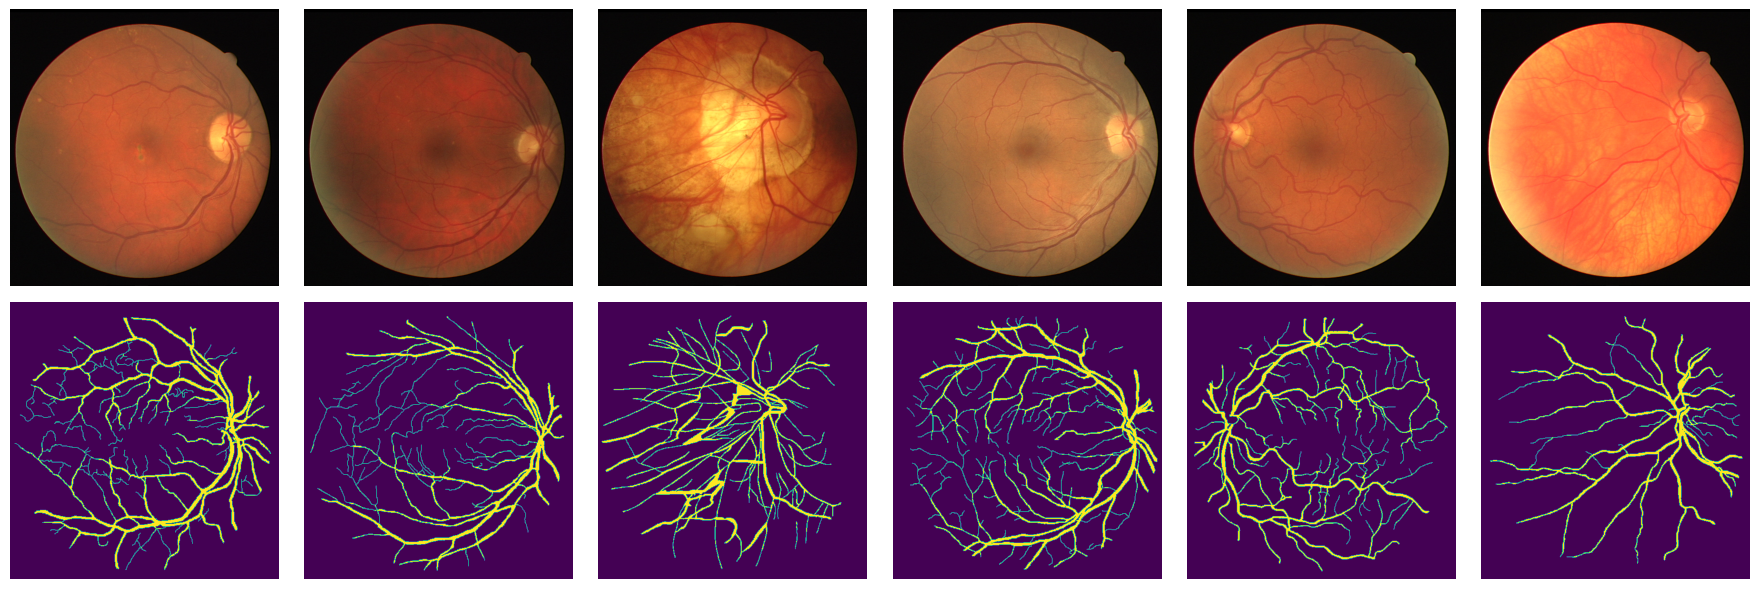

In [10]:
#PLotting images and masks to see everything looks fine 
plt.rcParams['figure.figsize'] = [18, 6]

images, labels = next(iter(train_loader))

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i], 0, 2), 0, 1))
    plt.axis('off')  


    plt.subplot(2, 6, i+7)
    plt.imshow(labels[i].squeeze())
    plt.axis('off')  
    plt.tight_layout()

plt.show()

In [11]:
#image shape = torch.Size([12, 3, 500, 500]) for train - efter er det jo så 550x550 for alle. 
# image shape = torch.Size([4, 3, 500, 500]) for validation 
# image shape = torch.Size([4, 3, 500, 500]) for testing 
print(images.shape)
print(labels.shape)
# OG SIZES: torch.Size([12, 3, 584, 565])

torch.Size([12, 3, 584, 565])
torch.Size([12, 1, 584, 565])


In [12]:
import torch
from torch.utils.data import Dataset

class PatchDataset(Dataset):
    def __init__(self, original_loader, patch_size=110, stride=110):
        self.original_loader = original_loader
        self.patch_size = patch_size
        self.stride = stride

    def __len__(self):
        # Returner det samlede antal patches, der kan genereres
        total_patches = 0
        for images, masks in self.original_loader:
            for i in range(images.size(0)):
                image = images[i]  # Hent individuelt billede
                H, W = image.size(1), image.size(2)
                total_patches += ((H - self.patch_size) // self.stride + 1) * ((W - self.patch_size) // self.stride + 1)
        return total_patches

    def __getitem__(self, idx):
        # Find det passende billede og maske baseret på idx
        for images, masks in self.original_loader:
            for i in range(images.size(0)):
                image = images[i]
                mask = masks[i]
                H, W = image.size(1), image.size(2)

                # Generer patches
                for y in range(0, H - self.patch_size + 1, self.stride):
                    for x in range(0, W - self.patch_size + 1, self.stride):
                        if idx == 0:
                            return image[:, y:y + self.patch_size, x:x + self.patch_size], mask[:, y:y + self.patch_size, x:x + self.patch_size]
                        idx -= 1
        raise IndexError("Index out of range in PatchDataset")


In [13]:
# Opret PatchDatasets fra eksisterende dataloaders
train_patch_dataset = PatchDataset(train_loader, patch_size=110, stride=110)
val_patch_dataset = PatchDataset(val_loader, patch_size=110, stride=110)
test_patch_dataset = PatchDataset(test_loader, patch_size=110, stride=110)

# Opret nye dataloaders til patches
train_patch_loader = torch.utils.data.DataLoader(train_patch_dataset, batch_size=128, shuffle=True) # before 12 
val_patch_loader = torch.utils.data.DataLoader(val_patch_dataset, batch_size=128, shuffle=False)
test_patch_loader = torch.utils.data.DataLoader(test_patch_dataset, batch_size=128, shuffle=False)


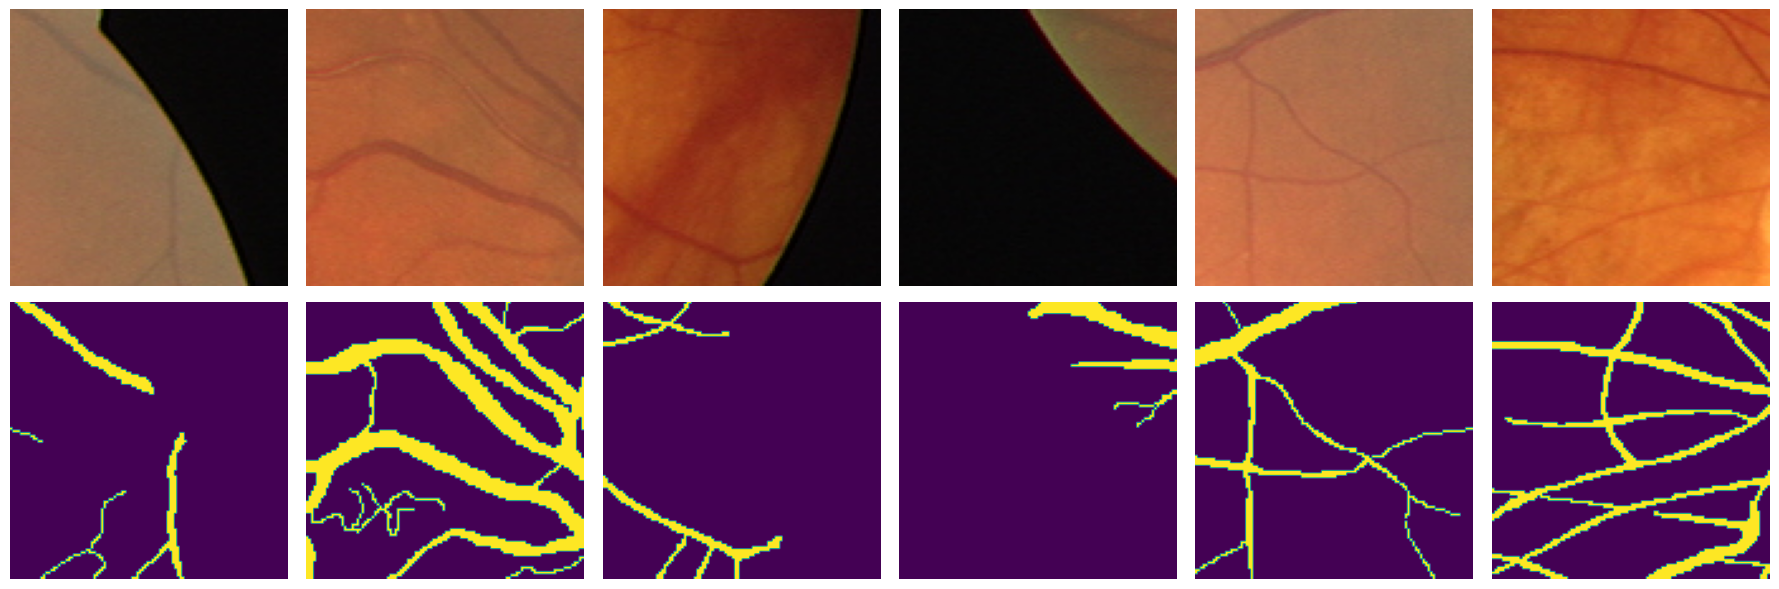

In [14]:
#PLotting images and masks to see everything looks fine - now each 550x550 image is cropped to 25 x 110x110
#PLotting images and masks to see everything looks fine 
plt.rcParams['figure.figsize'] = [18, 6]

images, labels = next(iter(train_patch_loader))

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i], 0, 2), 0, 1))
    plt.axis('off')  


    plt.subplot(2, 6, i+7)
    plt.imshow(labels[i].squeeze())
    plt.axis('off')  
    plt.tight_layout()

plt.show()

In [15]:
def train(model, opt, loss_fn, epochs, train_loader, val_loader):
    # Grab a batch of validation data
    X_test, Y_test = next(iter(val_loader))

    for epoch in range(epochs):
        
        print('* Epoch %d/%d' % (epoch + 1, epochs))

        avg_loss = 0
        model.train()  # Set model to training mode

        for X_batch, Y_batch in train_loader:
            # Move data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # Zero the gradients
            opt.zero_grad()

            # Forward pass
            Y_pred = model(X_batch)

            # Calculate loss
            loss = loss_fn(Y_batch, Y_pred)  # Correct order: model output first; Corrected, first the real, then predicted
            loss.backward()  # Backward pass
            opt.step()  # Update weights

            # Accumulate average loss
            avg_loss += loss.item() / len(train_loader)

        print(' - loss: %f' % avg_loss)

        # Plot results every 10th epoch
        if (epoch + 1) % 2 == 0:
            model.eval()  # Set model to evaluation mode
            with torch.no_grad():  # Disable gradient calculation for evaluation
                Y_hat = torch.sigmoid(model(X_test.to(device))).detach().cpu()

            # Clear previous output and plot the results
            clear_output(wait=True)  # Only if using Jupyter Notebook
            for k in range(4):  # Display first 4 images
                plt.subplot(2, 6, k + 1)
                plt.imshow(np.rollaxis(X_test[k].cpu().numpy(), 0, 3), cmap='gray')  # Move X_test to CPU
                plt.title('Real')
                plt.axis('off')

                plt.subplot(2, 6, k + 7)
                plt.imshow(Y_hat[k, 0].cpu().numpy(), cmap='gray')  # Move Y_hat to CPU
                plt.title('Output')
                plt.axis('off')

            plt.suptitle('%d / %d - loss: %f' % (epoch + 1, epochs, avg_loss))
            plt.show()


In [30]:
from UNet2 import bce_loss, dice_loss, focal_loss, bce_total_variation, focal_loss_chatten, stable_bce_loss

#Focal loss er lort 
#bce total variation ok med lr = 0.001
#focal loss chatten er lort
# dice loss er heller ikke god ( tror måske her at den bare vælger at sætte alt til ikke blood-vessels for at minimerer loss)
#
# chattens model er epic sammen med bceloss på lr = 0.001

#train(model, optim.Adam(model.parameters(), 0.001), bce_loss, 50, train_loader, val_loader) # good for training 500x500 images. 

train(model, optim.Adam(model.parameters(), 0.001), bce_loss, 100, train_patch_loader, val_patch_loader) # good for training 500x500 images. 
#60 epochs loss 0.19 50min (val set)


* Epoch 1/100


KeyboardInterrupt: 

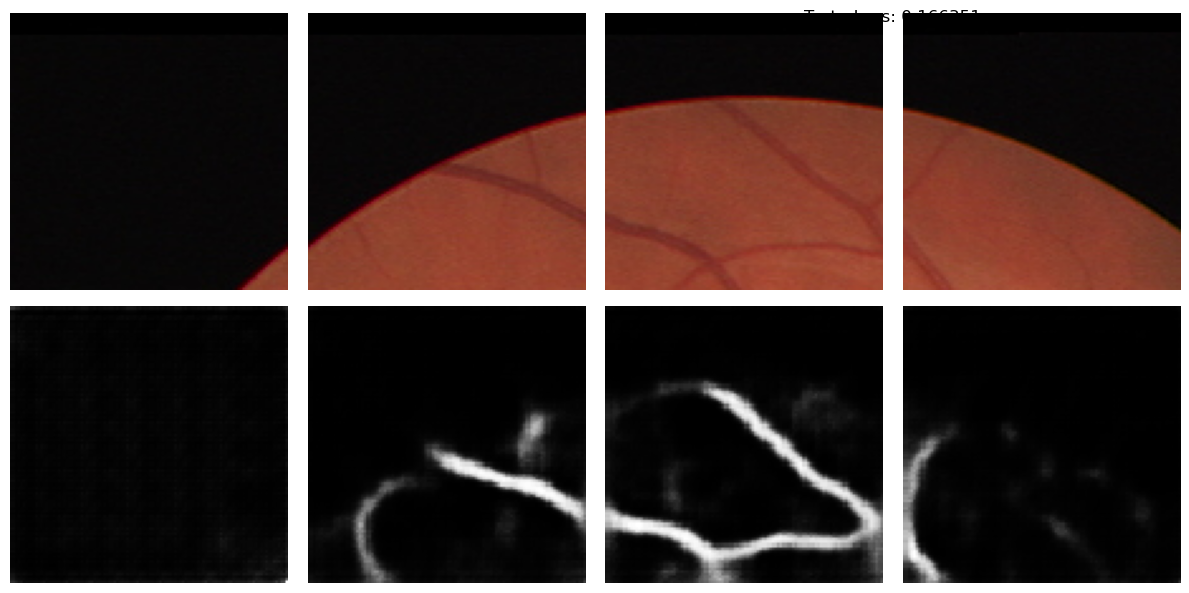

In [31]:

#test(model, test_loader, bce_loss)  For the 500x500 images. 
test(model, test_patch_loader, bce_loss) 
 

In [85]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_test_predictions(model, test_loader, device, num_images=3):
    model.eval()  # Set the model to evaluation mode
    X_test_batch, Y_test_batch = next(iter(test_loader))  # Fetch a batch of test data
    X_test_batch = X_test_batch.to(device)
    Y_test_batch = Y_test_batch.to(device)

    # Get predictions
    with torch.no_grad():
        Y_test_pred = model(X_test_batch)
        Y_test_pred = torch.sigmoid(Y_test_pred).detach().cpu()  # Apply sigmoid and move to CPU

    # Plotting
    fig, axs = plt.subplots(3, num_images, figsize=(15, 8))  # Adjust figure size to reduce gaps

    for k in range(num_images):  # Visualize the specified number of images
        # Original images
        axs[0, k].imshow(np.rollaxis(X_test_batch[k].cpu().numpy(), 0, 3), cmap='gray')
        axs[0, k].axis('off')

        # Ground truth images
        axs[1, k].imshow(Y_test_batch[k].cpu().numpy().squeeze(), cmap='gray')  # Squeeze to remove the channel dimension
        axs[1, k].axis('off')

        # Predicted images
        axs[2, k].imshow(Y_test_pred[k, 0], cmap='gray')  # Already a 2D array after removing the channel dimension
        axs[2, k].axis('off')

    # Add rotated labels outside the subplots using fig.text
    fig.text(0.04, 0.75, 'Original', fontsize=24, rotation=90, va='center')
    fig.text(0.04, 0.5, 'Ground Truth', fontsize=24, rotation=90, va='center')
    fig.text(0.04, 0.25, 'Prediction', fontsize=24, rotation=90, va='center')

    

    plt.subplots_adjust(wspace=-0.3, hspace=0.01)  # Adjust spacing between plots
    plt.tight_layout()

    plt.show()



In [109]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_test_predictions(model, test_loader, device, num_images=4):
    model.eval()  # Set the model to evaluation mode
    X_test_batch, Y_test_batch = next(iter(test_loader))  # Fetch a batch of test data
    X_test_batch = X_test_batch.to(device)
    Y_test_batch = Y_test_batch.to(device)

    # Get predictions
    with torch.no_grad():
        Y_test_pred = model(X_test_batch)
        Y_test_pred = torch.sigmoid(Y_test_pred).detach().cpu()  # Apply sigmoid and move to CPU

    # Plotting
    fig, axs = plt.subplots(3, num_images, figsize=(16, 10))  # Larger figure for clearer view

    # Set a nicer colormap
    cmap = 'inferno'  # Try using 'plasma', 'magma', 'inferno', etc.
    
    for k in range(num_images):  # Visualize the specified number of images
        # Original images
        axs[0, k].imshow(np.rollaxis(X_test_batch[k].cpu().numpy(), 0, 3), cmap='gray')
        axs[0, k].axis('off')

        # Ground truth images
        axs[1, k].imshow(Y_test_batch[k].cpu().numpy().squeeze(), cmap='gray')  # Squeeze to remove the channel dimension
        axs[1, k].axis('off')

        # Predicted images with a colorful colormap
        img = axs[2, k].imshow(Y_test_pred[k, 0], cmap='gray')  # Apply chosen colormap
        axs[2, k].axis('off')

    # Add rotated labels outside the subplots using fig.text
    fig.text(0.04, 0.82, 'Original', fontsize=30, rotation=90, va='center', color = 'white')
    fig.text(0.04, 0.5, 'Ground Truth', fontsize=30, rotation=90, va='center' , color = 'white')
    fig.text(0.04, 0.18, 'Prediction', fontsize=30, rotation=90, va='center', color = 'white')


    # Adjust layout to avoid overlap
    plt.subplots_adjust(wspace=0.1, hspace=0.2)  # Adjust spacing between plots
    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar on the right
    plt.show()


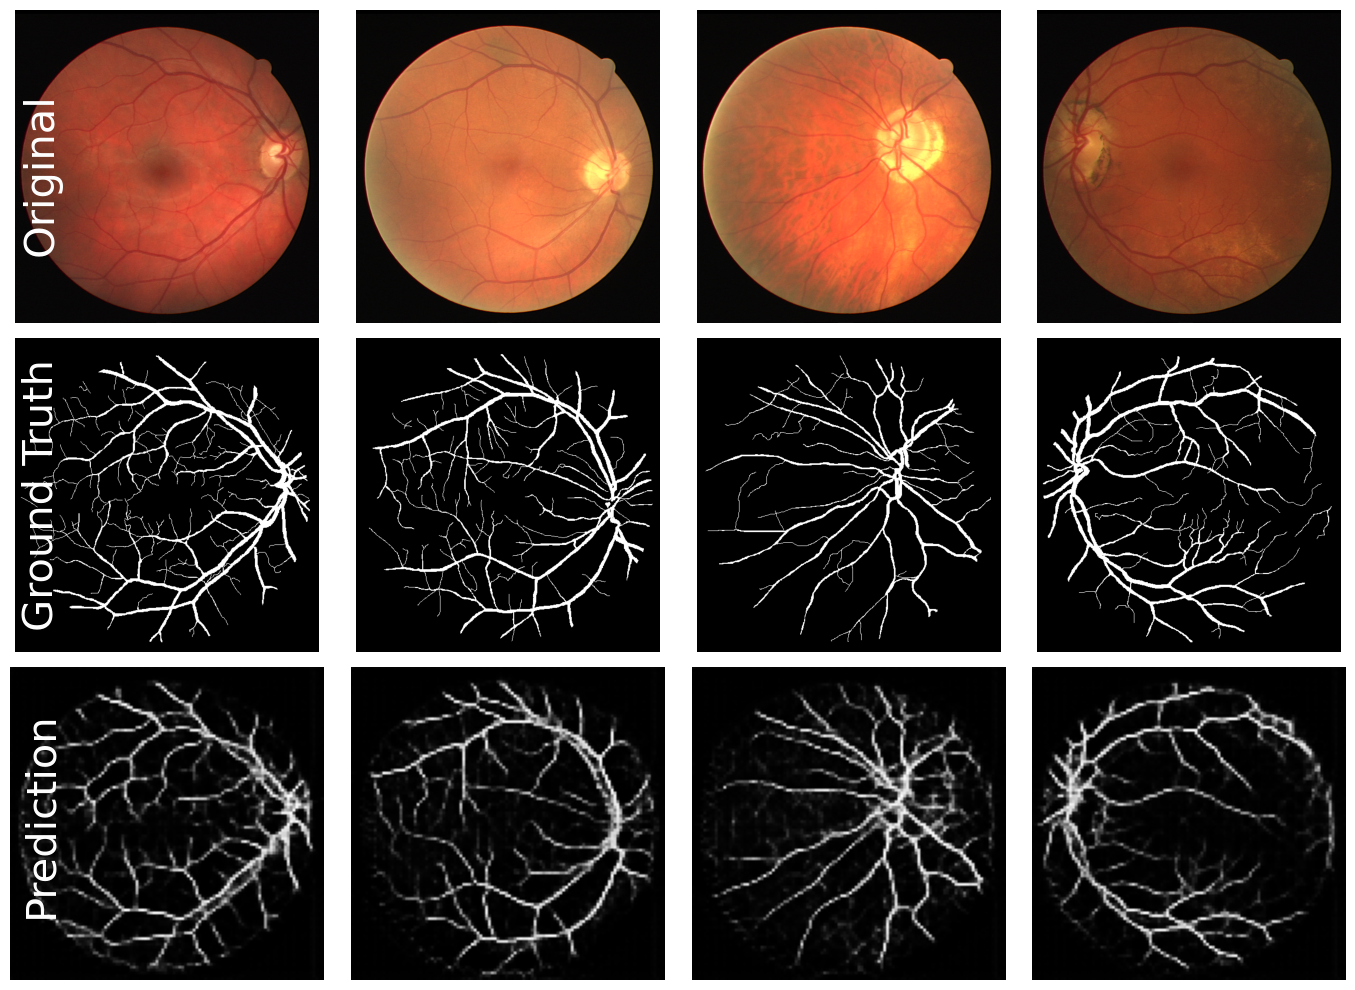

In [110]:
visualize_test_predictions(model, test_loader, device)

## Notes about the optimization of the encoder architecture for the DRIVE dataset. 
# potentielt set antallet af downsampling lag up, da vi skal have et featuremap på en skala så man kan se blodårer ? (selvom det gør billedet større egentlig?:)

**START PERFORMANCE**: ( den taget direkte fra exercise_2_2_segmentation)
* >Loss: 0.937822, Dice: 0.1248, IoU: 0.0666, Accuracy: 0.8588, Sensitivity: 0.0000, Specificity: 1.0000

**Har tilføjet batchnormalisation: PERFORMANCE**: 
* >Test Loss: 0.807360, Dice: 0.1492, IoU: 0.0806, Accuracy: 0.8720, Sensitivity: 0.0016, Specificity: 0.9996

**Increasing number of channelsperformance: (before just 64 channels all the way) - (after: 2*x channels (max 512), and then 1/5*x channels (64))**
* >Test Loss: 0.711504, Dice: 0.0701, IoU: 0.0363, Accuracy: 0.4520, Sensitivity: 0.3811, Specificity: 0.4990

OBSERVATION.. laver mange maxpoolings, som fanger større features, dog er blood-vessels en meget lille feature. 
chat siger at man kan bruge convTranspose2d istedet for upsample, da vi her lærer flere af de små features.
**implementerer nn.ConvTranspose2d i upsamplingdelen sammen med bceloss på lr = 0.001 og 50 epochs, Performance**
train(model, optim.Adam(model.parameters(), 0.001), bce_loss, 50, train_loader, val_loader)
* > Test Loss: 0.638876, Dice: 0.2842, IoU: 0.1657, Accuracy: 0.7173, Sensitivity: 0.6456, Specificity: 0.7687

**Now the problem of overfitting occurs, so now the dataset is cropped to 550x550 (before 500x500), and then each image is cropped into**
**25 images with 110x110 images, batchsize = 128, epochs = 100, bceloss, lr = 0.001**
* > Test Loss: 0.166351, Dice: 0.0134, IoU: 0.0068, Accuracy: 0.9374, Sensitivity: 0.3996, Specificity: 0.9867
* > men lol, det tager altså en times tid at træne - tror allerede den var på 0.2 efter 60 epochs 



## SCORES. 
1.gang  Test Loss: 0.166351, Dice: 0.0134, IoU: 0.0068, Accuracy: 0.9374, Sensitivity: 0.3996, Specificity: 0.9867
##
2. gang: Test Loss: 0.190478, Dice: 0.0491, IoU: 0.0252, Accuracy: 0.9271, Sensitivity: 0.1242, Specificity: 0.9949